## LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import string
import seaborn as sns
import re
import math
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw

# imports to display the decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

c:\users\fratt\appdata\local\programs\python\python38\lib\site-packages\sklearn\externals\six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


In [4]:
plt.rcParams["figure.figsize"] = (12,8)

## PLOTTING FUNCTIONS

In [5]:
def plot_features_importance(clf, feature_names, num_feat_to_plot):
    feat_imp = pd.Series(clf.feature_importances_, feature_names).sort_values(ascending = False)
    ax = feat_imp[:num_feat_to_plot].plot(kind='barh', title='Feature Importance')
    ax.invert_yaxis()
    
def plot_2d_clusters(X, y):
    svd = TruncatedSVD(n_components = 2)
    X_svd = svd.fit_transform(X)
    sns.scatterplot(X_svd[:, 0], X_svd[:, 1], hue = y, palette = {'pos': 'g', 'neg':'r'})
    
def plot_3d_clusters(X,y):
    svd = TruncatedSVD(n_components = 3)
    X_svd = svd.fit_transform(X)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    pos_mask = y == 'pos'
    neg_mask = y == 'neg'
    ax.scatter(X_svd[neg_mask,0], X_svd[neg_mask,2], X_svd[neg_mask,1], c = 'r', label = 'neg')
    ax.scatter(X_svd[pos_mask,0], X_svd[pos_mask,2], X_svd[pos_mask,1], c = 'g', label = 'pos')
    plt.legend()
    plt.show()
    
def plot_wordcloud(X_tfidf, word_positions):
    count_sum = np.sum(X_tfidf, axis=0)
    count_sum = np.asarray(count_sum).reshape(-1) 
    
    top_indices = count_sum.argsort()[-100:]
    term_weights = {word_positions[idx]: count_sum[idx] for idx in top_indices}
    
    wc = WordCloud(width=1200, height=800, background_color="white")
    wordcloud = wc.generate_from_frequencies(term_weights)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_tree(gb_clf, features, tree_number):
    # workaround to make graphviz work in my enviroment
    os.environ['PATH'] = os.environ['PATH']+';'+ "C:\\Program Files (x86)\\Graphviz2.38\\bin"
    
    tree = gb_clf.estimators_[tree_number, 0]
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, rounded=True, feature_names = features, max_depth = 5, impurity = False, filled = True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    return Image(graph.create_png())

def plot_confusion_matrix(y, y_pred, normalize = 'true'):
    conf = confusion_matrix(y_valid, y_valid_pred, normalize = normalize)
    sns.heatmap(conf, annot = True, xticklabels = ['neg','pos'], yticklabels = ['neg','pos'], fmt = '.2f', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## 1. DATA EXPLORATION

In [6]:
df = pd.read_csv("development.csv")

In [7]:
# null-values check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28754 entries, 0 to 28753
Data columns (total 2 columns):
text     28754 non-null object
class    28754 non-null object
dtypes: object(2)
memory usage: 449.4+ KB


pos    19532
neg     9222
Name: class, dtype: int64


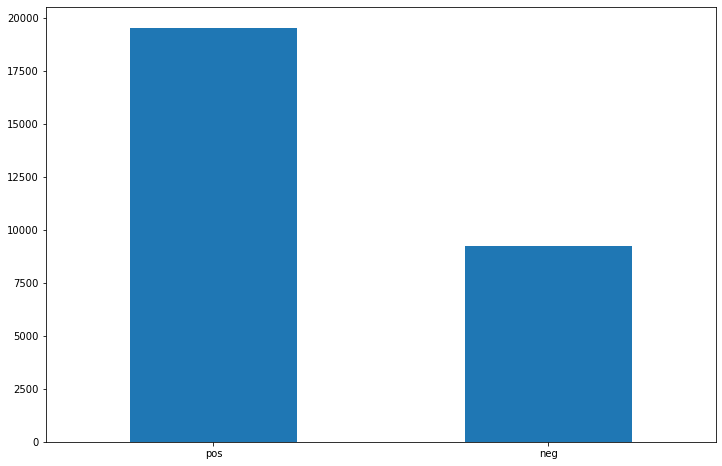

In [8]:
#  we can easily see that there are way more positive then negative reviews --> unbalanced dataset
df["class"].value_counts().plot(kind = 'bar', rot = 0)
print(df["class"].value_counts())

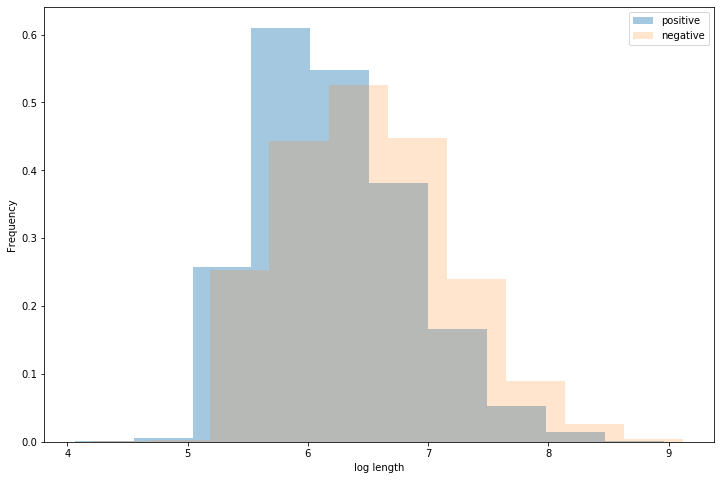

In [9]:
# try to inspect whether the log_length of the reviews could be useful to classify
pos_log_length = df["text"][df["class"] == 'pos'].apply(lambda x: math.log(len(x)))
neg_log_length = df["text"][df["class"] == 'neg'].apply(lambda x: math.log(len(x)))

pos_log_length.plot(kind = 'hist', bins = 10, label = 'positive', density = True, alpha = 0.4)
neg_log_length.plot(kind = 'hist', bins = 10, label = 'negative', density = True, alpha = 0.2)

plt.xlabel('log length')
plt.legend()
plt.show()

## 2. PREPROCESSING

In [39]:
class StemTransformer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('italian')
        self.stopwords =  sw.words('Italian') + ["essere", "avere" , "il" , "lo" , "la" , "i" , "gli" , "le" , "uno" , "una" , "un", "hotel", "camera", "albergo", "stato", "stati", "colazione", "personale", "cosa", "cose", "molto"]
        
    def __call__(self, document):
        document = re.sub('[^a-zA-Z]', ' ', document)
        tokens = []
        for t in word_tokenize(document):
            t = t.strip()
            t = t.lower()
#             word 'non' is very important but would have been ecluded by the stopword filter
            if (len(t) > 2 and t not in string.punctuation and t not in self.stopwords) or (t == 'non'):
                tokens.append(self.stemmer.stem(t))
        return ' '.join(tokens)

In [40]:
# text-stemTokenization through the StemTransformer
stem_transformer = StemTransformer()
transformed_reviews = df["text"].apply(stem_transformer).values

In [41]:
# feature extraction through a count vectorization
vectorizer = CountVectorizer(ngram_range = (1,2), min_df = 15, max_df = 0.7)
vectorizer.fit(transformed_reviews)
features = vectorizer.get_feature_names()

In [42]:
X = vectorizer.transform(transformed_reviews)
y = df["class"].values

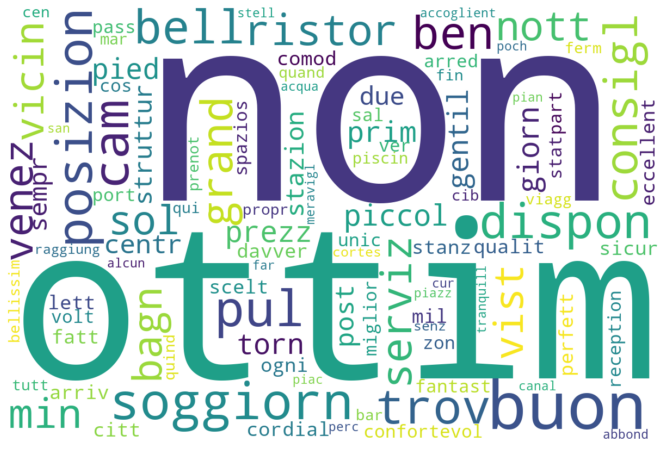

In [43]:
# plotting wordcloud for positive reviews
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
plot_wordcloud(X[y == 'pos'], word_positions)

## 3. MODEL SELECTION

In [44]:
# exploiting the stratify parameter of train_test_split to keep the same unbalanced proportion in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [62]:
# Grid seraching on those parameters that are more likely to affect the classification
# the others are fixed following literature suggestions and values typically used
params = {"n_estimators": [600, 800, 1000], "learning_rate" : [0.05, 0.1, 0.2], "subsample" : [0.8,0.9,0.95]}

In [63]:
clf = GradientBoostingClassifier(random_state = 42,max_features = 'sqrt',  min_samples_split = 0.005, min_samples_leaf = 30 , max_leaf_nodes = 20,  max_depth = 15 )
grid_search = GridSearchCV(clf, param_grid = params, cv = 5, scoring='f1_weighted', n_jobs = -1)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
best_clf.fit(X_train,y_train)
print("Best score obtained on training set:", grid_search.best_score_)

Best score obtained on training test: 0.9634284740274441


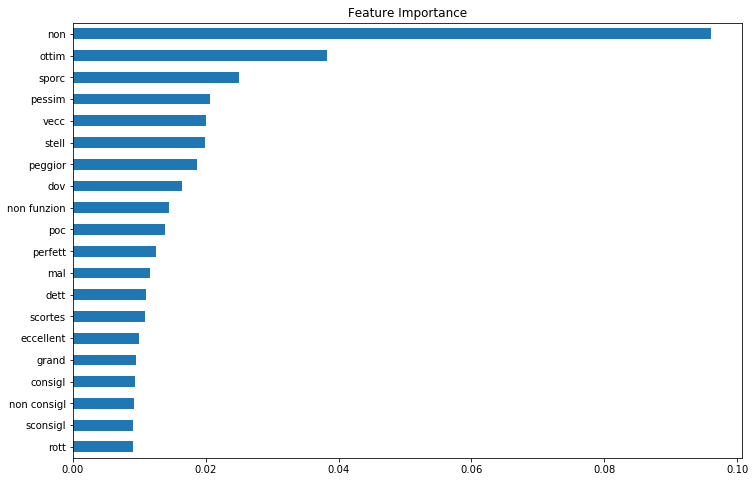

In [64]:
# plotting the 20 most importante features for the splitting in the variuos trees
plot_features_importance(best_clf, features, 20)

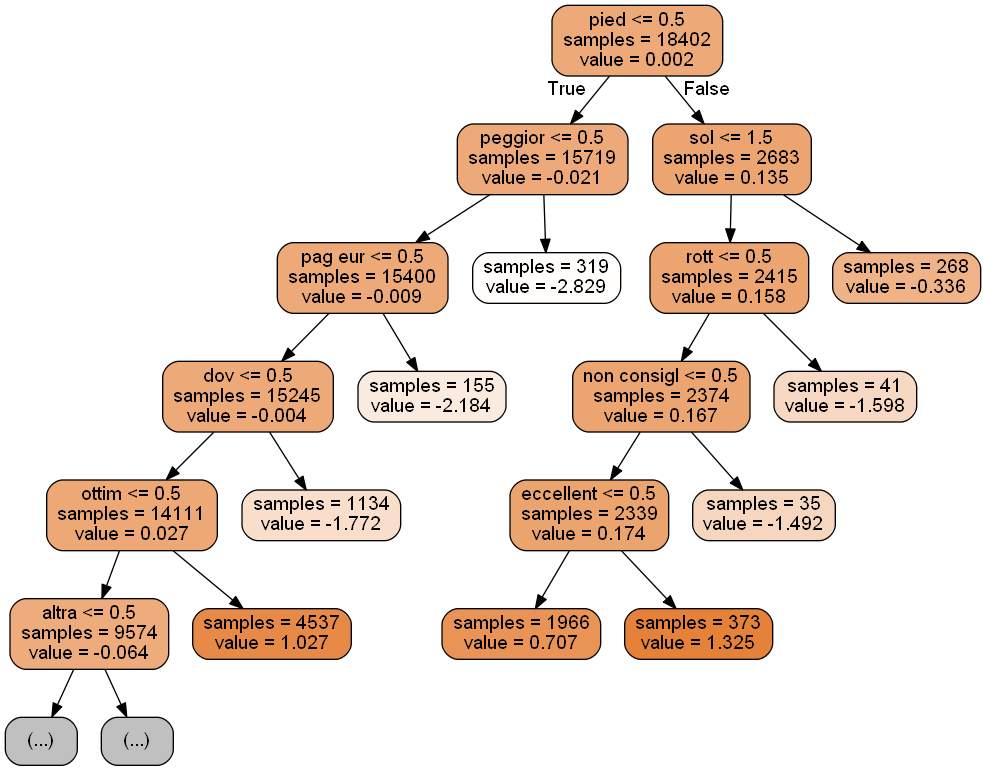

In [78]:
#  plotting a random tree from the forest
plot_tree(best_clf, features, 1)

In [66]:
y_valid_pred = best_clf.predict(X_valid)
score = f1_score(y_valid, y_valid_pred, average = "weighted")
print("Best score obtained on validation set:", score)

Best score obtained on validation test: 0.9626909991522078


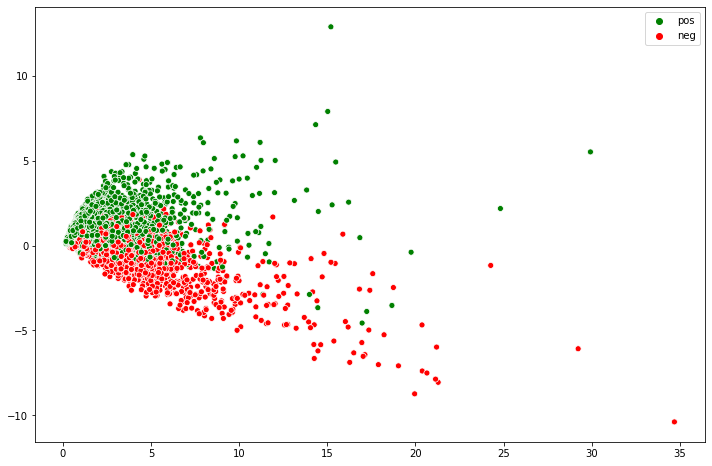

In [67]:
plot_2d_clusters(X_valid, y_valid_pred)

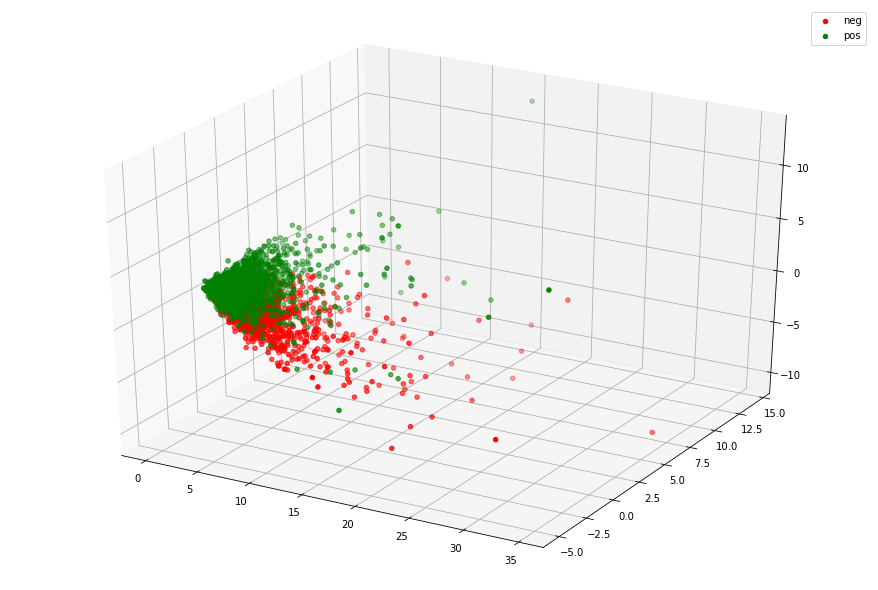

In [68]:
plot_3d_clusters(X_valid, y_valid_pred)

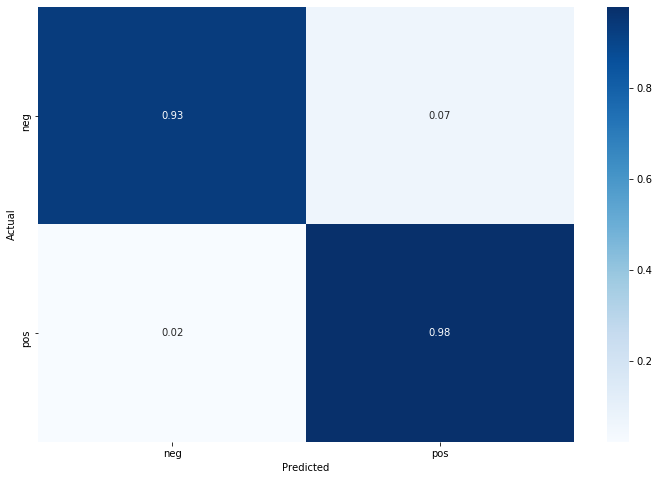

              precision    recall  f1-score   support

         neg       0.95      0.93      0.94      1844
         pos       0.97      0.98      0.97      3907

    accuracy                           0.96      5751
   macro avg       0.96      0.95      0.96      5751
weighted avg       0.96      0.96      0.96      5751



In [69]:
# plotting the confusion matrix and inspecting the classification report to estimate how biased the classifier is
plot_confusion_matrix(y_valid, y_valid_pred)
print(classification_report(y_valid, y_valid_pred))

In [53]:
# re-fitting the best classifier on the whole development set
best_clf.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=20,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=0.005,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 4. PREDICTION

In [70]:
eval_df = pd.read_csv("evaluation.csv")

In [71]:
transformed_test_reviews = eval_df["text"].apply(stem_transformer).values

In [72]:
X_test = vectorizer.transform(transformed_test_reviews)

In [73]:
y_test_pred = best_clf.predict(X_test)

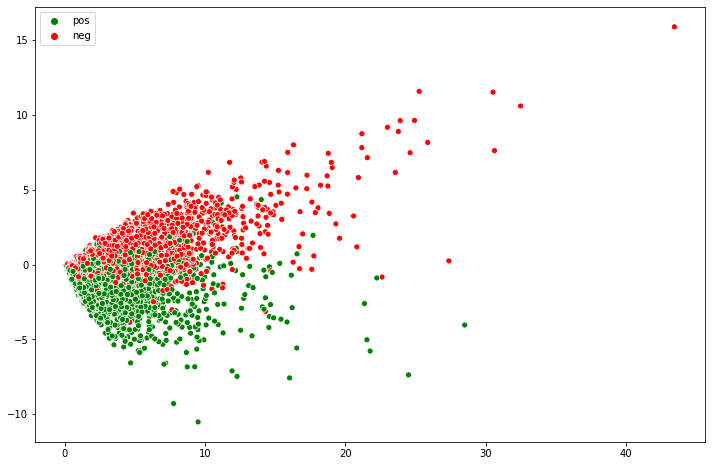

In [74]:
plot_2d_clusters(X_test, y_test_pred)

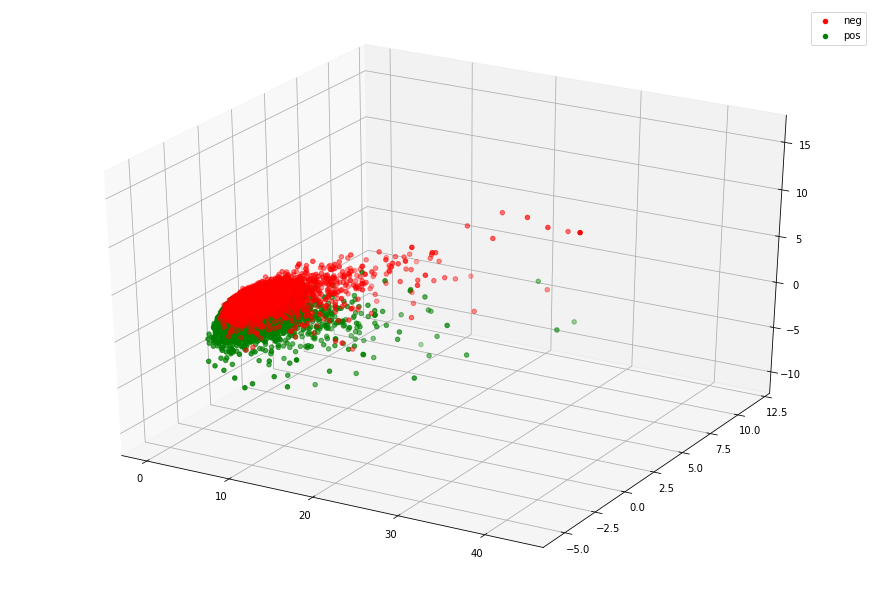

In [75]:
plot_3d_clusters(X_test, y_test_pred)

In [76]:
eval_df["Id"] = eval_df.index
eval_df["Predicted"] = y_test_pred
to_file_df = eval_df.drop("text", axis = 1)
to_file_df.to_csv("predictions.csv", index = False)